# Develop, evaluate, and score a forecasting model for electricity generation

In [1]:
"""
 Introduction

In this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.

Forecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.

The main steps in this notebook are:

1. Load the data
2. Understand and process the data using exploratory data analysis
3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature
4. Save the final machine learning model and make predictions
5. Demonstrate the model performance via visualizations in Power BI

Thesis

What percentage of fuel generation will come from Natural Gas in the coming months?

"""

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 3, Finished, Available)

"\n Introduction\n\nIn this notebook, you'll see Microsoft Fabric's end-to-end data science workflow for a forecasting model. This scenario uses the historic sales data to predict the sales for different categories of products at a superstore.\n\nForecasting is a crucial asset in sales, harnessing historical data and predictive methods to provide insights into future trends. By analyzing past sales, identifying patterns, and learning from consumer behavior, businesses can optimize inventory, production, and marketing strategies. This proactive approach enhances adaptability, responsiveness, and overall performance of businesses in a dynamic marketplace.\n\nThe main steps in this notebook are:\n\n1. Load the data\n2. Understand and process the data using exploratory data analysis\n3. Train a machine learning model using an open source software package called `SARIMAX` and track experiments using MLflow and Fabric Autologging feature\n4. Save the final machine learning model and make pre

In [2]:
pip install pmdarima

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 4, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Libraries and Variables

In [3]:
# Importing required libraries
import warnings
import itertools
# Record the notebook running time
import time
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
# Set up MLflow for experiment tracking
import mlflow
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
# Import required libraries for model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pyspark.sql.functions import col, to_date
from pmdarima.arima import auto_arima
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from statsmodels.stats.diagnostic import acorr_ljungbox
import os, requests
import statsmodels.api as sm
from mlflow import MlflowClient
from pprint import pprint
"""
`Statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models
It also allows you to conduct statistical tests and statistical data exploration.
"""

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 5, Finished, Available)

'\n`Statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models\nIt also allows you to conduct statistical tests and statistical data exploration.\n'

In [4]:
"""
Define Variables
"""

EXPERIMENT_NAME = "EIA-forecasting-UAT"  # MLflow experiment name

ts = time.time()

"""
ML Flow: Machine Learning

Autologging in Microsoft Fabric extends the MLflow autologging capabilities by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to the workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in the workspace. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).
"""

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging



StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 6, Finished, Available)

## Step 1: Datasets

### Training Data

In [5]:
"""
Step 1: Read the dataset from the lakehouse
"""

df = spark.sql(
"""
SELECT 
Type.FuelClass Fuel_class
,Ops.date_full Operating_date
,sum(Fact.NetGenerationElectricityMWh) Electricity_generated
FROM LH_EIA_GOLD.fact_generation Fact
left outer join dim_fuel_type Type on Fact.FuelTypeKey = Type.FuelTypeKey
left outer join dim_date Ops on Fact.SurveyDateKey = Ops.date_id 
where Ops.date_full > '1999-12-31'
GROUP BY 
Type.FuelClass 
,Ops.date_full 
"""
)

Training_data = df

display(Training_data)

"""
Data Reformatting
"""
Training_data = Training_data.withColumnRenamed("Fuel_Class", "Fuel class")
Training_data = Training_data.withColumnRenamed("Operating_Date", "Operating date")
Training_data = Training_data.withColumnRenamed("Electricity_Generated", "Electricity generated")
Training_data = Training_data.withColumn("Operating date", to_date(col("Operating date")))
# Convert the PySpark DataFrame to a Pandas DataFrame
Training_data = Training_data.toPandas()

"""
How to specify or convert the data types post-conversion in the Pandas DataFrame
"""

# Assuming Training_data is your Pandas DataFrame
Training_data['Fuel class'] = Training_data['Fuel class'].astype(str)
# Assuming Training_data is your Pandas DataFrame
Training_data['Operating date'] = pd.to_datetime(Training_data['Operating date'])
# Convert the 'Electricity generated' column to int
Training_data['Electricity generated'] = Training_data['Electricity generated'].astype(int)

"""
The dataset is structured on a daily basis
The goal is to develop a model to forecast the sales on a monthly basis, you need to resample on the column `Order Date`.

1. group the `Furniture` category by `Order Date` and then 
2. calculate the sum of the `Sales` column for each group in order to determine the total sales for each unique `Order Date`. 
3. resample the `Sales` column using the `MS` frequency to aggregate the data by month and then you calculate the mean sales value for each month.
"""

# Data preprocessing
Training_data = Training_data.sort_values('Operating date')
Training_data.isnull().sum()
Training_data = Training_data.groupby('Operating date')['Electricity generated'].sum().reset_index()
Training_data = Training_data.set_index('Operating date')

"""
Add a docstring for exactly how this works. 
Explain interpolation for example. 
"""
# Assuming Historical_data is your DataFrame with a DateTime index
Training_data_resampled = Training_data['Electricity generated'].resample('MS').mean()
# Forward-fill missing values for the first few entries
Training_data_resampled_filled = Training_data_resampled.ffill()
# Interpolate missing values for the rest of the entries
Training_data_resampled_interpolated = Training_data_resampled_filled.interpolate(method='linear')
Training_data = Training_data_resampled_interpolated

Training_data = Training_data.fillna(0) # Fill NaN values with zero
Training_data = Training_data.astype('int64')
Training_data = Training_data.reset_index()
Training_data['Operating date'] = pd.to_datetime(Training_data['Operating date'])
maximim_date = Training_data.reset_index()['Operating date'].max()
Training_data = Training_data[Training_data['Operating date'].dt.strftime('%Y-%m-%d') < "2022-01-01"] # training data
# Training_data.sort_index(inplace=True)
Training_data = Training_data.set_index(['Operating date'])

print(Training_data)
display(maximim_date)
print(type(Training_data))
display(Training_data)

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5bcf2197-8fde-4349-9c7e-bb30bf325f1f)

                Electricity generated
Operating date                       
2013-01-01                  348967380
2013-02-01                  309728081
2013-03-01                  325398836
2013-04-01                  299332869
2013-05-01                  322155642
...                               ...
2021-08-01                  414625561
2021-09-01                  349408658
2021-10-01                  321850805
2021-11-01                  315862914
2021-12-01                  338596265

[108 rows x 1 columns]


Timestamp('2023-05-01 00:00:00')

<class 'pandas.core.frame.DataFrame'>


SynapseWidget(Synapse.DataFrame, 9bbd1000-a4ba-4901-8e13-52a67ca59ed6)

### Validation Data

In [6]:
"""
Step 1: Read the dataset from the lakehouse
"""

df = spark.sql(
"""
SELECT 
Type.FuelClass Fuel_class
,Ops.date_full Operating_date
,sum(Fact.NetGenerationElectricityMWh) Electricity_generated
FROM LH_EIA_GOLD.fact_generation Fact
left outer join dim_fuel_type Type on Fact.FuelTypeKey = Type.FuelTypeKey
left outer join dim_date Ops on Fact.SurveyDateKey = Ops.date_id 
where Ops.date_full > '2021-12-31' and Ops.date_full < '2023-01-01'
GROUP BY 
Type.FuelClass 
,Ops.date_full 
"""
)

validation_data = df

"""
Data Reformatting
"""
validation_data = validation_data.withColumnRenamed("Fuel_Class", "Fuel class")
validation_data = validation_data.withColumnRenamed("Operating_Date", "Operating date")
validation_data = validation_data.withColumnRenamed("Electricity_Generated", "Electricity generated")
validation_data = validation_data.withColumn("Operating date", to_date(col("Operating date")))
# Convert the PySpark DataFrame to a Pandas DataFrame
validation_data = validation_data.toPandas()

# Type conversion is your Pandas DataFrame
validation_data['Fuel class'] = validation_data['Fuel class'].astype(str)
validation_data['Operating date'] = pd.to_datetime(validation_data['Operating date'])
validation_data['Electricity generated'] = validation_data['Electricity generated'].astype(int)

# Data preprocessing
validation_data = validation_data.sort_values('Operating date')
validation_data.isnull().sum()
validation_data = validation_data.groupby('Operating date')['Electricity generated'].sum().reset_index()
validation_data = validation_data.set_index('Operating date')

print(validation_data)
display(validation_data)

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 8, Finished, Available)

                Electricity generated
Operating date                       
2022-01-01                  378497411
2022-02-01                  328200156
2022-03-01                  326209660
2022-04-01                  304653293
2022-05-01                  343801803
2022-06-01                  382305595
2022-07-01                  425611127
2022-08-01                  414375580
2022-09-01                  351970184
2022-10-01                  315623919
2022-11-01                  324379919
2022-12-01                  365006844


SynapseWidget(Synapse.DataFrame, d21d8c67-65b9-4b7f-a12f-06d06d69dd0e)

## Step 2: Statistical Analysis

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 9, Finished, Available)

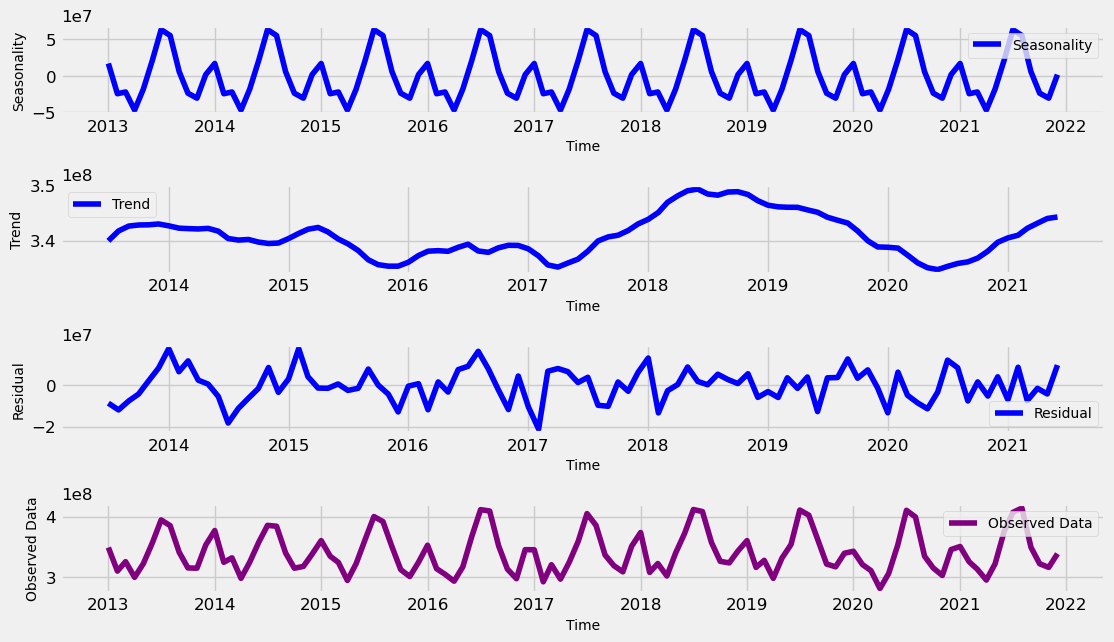

'\nDoing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.\nUnderstanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.\n'

In [7]:
"""
Statistical analysis

A time series tracks four data elements at set intervals in order to determine the variation of those four elements in the time series pattern. These elements include:

- **Level:** Refers to the fundamental component that represents the average value for a specific time period.

- **Trend:** Describes whether the time series is decreasing, constant, or increasing over time.

- **Seasonality:** Describes the periodic signal in the time series and looks for cyclic occurrences that affect the time series' increasing or decreasing patterns.

- **Noise/Residual:** Refers to the random fluctuations and variability in the time series data that cannot be explained by the model.

In the following, you will observe the above four components for your dataset after the pre-processing.
"""


# Decompose the time series into its components using statsmodels
result = sm.tsa.seasonal_decompose(Training_data, model='additive')

# Labels and corresponding data for plotting
components = [('Seasonality', result.seasonal),
              ('Trend', result.trend),
              ('Residual', result.resid),
              ('Observed Data', Training_data)]

# Create subplots in a grid
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.8)  # Adjust vertical space
axes = axes.ravel()

# Plot the components
for ax, (label, data) in zip(axes, components):
    ax.plot(data, label=label, color='blue' if label != 'Observed Data' else 'purple')
    ax.set_xlabel('Time')
    ax.set_ylabel(label)
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(fontsize=10)

plt.show()

"""
Doing time series analysis. We are preforming seasonal decomposition. This gives an overall understanding of how these components contribute to the entire time series.
Understanding the seasonality, trend, and noise in the forecasting data through the above plots allows to capture underlying patterns, and develop models that make more accurate predictions that are resilient to random fluctuations.
"""

In [8]:
"""
Statistical Measure of accuracy
"""
def mean_absolute_error(y_true, y_pred):
    """
    Calculate Mean Absolute Error (MAE)
    
    Args:
    y_true: List or array containing true values
    y_pred: List or array containing predicted values
    
    Returns:
    mae: Mean Absolute Error
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred must be the same.")
    
    total_error = 0
    for true_val, pred_val in zip(y_true, y_pred):
        total_error += abs(true_val - pred_val)
    
    mae = total_error / len(y_true)
    return mae

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 10, Finished, Available)

## Step 3: Model Training and Tracking

With your data in place, you can define the forecasting model. Apply the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) in this notebook. SARIMAX is a time series forecasting model that extends SARIMA to include exogenous variables. It combines autoregressive (AR) and moving average (MA) components, seasonal differencing, and external predictors to make accurate and flexible forecasts for time series data, making it a powerful tool for various forecasting tasks.

You will also use MLfLow and Fabric Autologging to track the experiments. Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

"""
SARIMAX, or Seasonal Autoregressive Integrated Moving Average with Exogenous Factors, 
a time series forecasting method that extends the traditional ARIMA model to include seasonal components and exogenous variables. 

The acronym breaks down as follows:
- Seasonal: Accounts for patterns that repeat over known intervals or seasons.
- ARIMA: Stands for Autoregressive Integrated Moving Average, a model used for understanding and forecasting time series data.
- X: Denotes the inclusion of exogenous variables, which are external factors that can influence the time series being forecasted.

In SARIMAX models, the seasonal and non-seasonal components of the time series data are modeled separately. 
It's a powerful tool for handling time series data that exhibits both seasonal patterns and relationships with other variables.
It's often used
"""

### Hyperparameter tuning

SARIMAX takes into account the parameters involved in regular ARIMA mode `(p,d,q)` and also adds the seasonality parameters `(P,D,Q,s)`. These arguments to SARIMAX model are called order `(p,d,q)` and seasonal order `(P,D,Q,s)` respectively and hence 7 parameters to tune. Prior to model training, you need to set up these parameters which are defined in the following.

#### Order Parameters `(p, d, q)`:
- `p`: The order of the autoregressive (AR) component, indicating how many past observations are considered. It is also known as the AR order.
- `d`: The degree of differencing required to make the time series stationary. It is also known as the differencing order.
- `q`: The order of the moving average (MA) component, indicating how many past white noise error terms are considered. It is also known as the MA order.

#### Seasonal Order Parameters `(P, D, Q, s)`:

- `P`: The seasonal order of the autoregressive (AR) component, similar to `p` but for the seasonal part.
- `D`: The seasonal order of differencing, similar to `d` but for the seasonal part.
- `Q`: The seasonal order of the moving average (MA) component, similar to `q` but for the seasonal part.
- `s`: The number of time steps per seasonal cycle (e.g., 12 for monthly data with a yearly seasonality).


 The autoregressive order `p` represents the number of past observations in the time series that are used to predict the current value. Typically, `p` should be a non-negative integer. Common values for `p` are usually in the range of 0 to 3, although higher values are possible depending on the specific characteristics of the data. A higher p indicates a longer memory of past values in the model.

 The moving average order `q` represents the number of past white noise error terms that are used to predict the current value. Similar to `p`, `q` should also be a non-negative integer. Common values for `q` are typically in the range of 0 to 3, but higher values may be necessary for certain time series. A higher `q` indicates a stronger reliance on past error terms to make predictions.

 The differencing order `d` represents the number of times the time series needs to be differenced to achieve stationarity. `d` should be a non-negative integer. Common values for `d` are usually in the range of 0 to 2. A `d` value of 0 means the time series is already stationary, while higher values indicate the number of differencing operations required to make it stationary.


#### Determine Optional Parameters:
- The `enforce_stationarity` parameter controls whether or not the model should enforce stationarity on the time series data before fitting the SARIMAX model. When `enforce_stationarity` is set to `True` (the default), it indicates that the SARIMAX model should enforce stationarity on the time series data. This means that the SARIMAX model will automatically apply differencing to the data to make it stationary, as specified by the `d` and `D` orders, before fitting the model. This is a common practice because many time series models, including SARIMAX, assume that the data is stationary. If your time series is non-stationary (e.g., it exhibits trends or seasonality), it is generally a good practice to set `enforce_stationarity` to `True` and let the SARIMAX model handle the differencing to achieve stationarity. If your time series is already stationary (e.g., it has no trends or seasonality), you can set `enforce_stationarity` to `False` to avoid unnecessary differencing.

- The `enforce_invertibility` parameter controls whether or not the model should enforce invertibility on the estimated parameters during the optimization process. When `enforce_invertibility` is set to `True` (the default), it indicates that the SARIMAX model should enforce invertibility on the estimated parameters. Invertibility ensures that the model is well-defined and that the estimated autoregressive (AR) and moving average (MA) coefficients are within the range of stationarity. Enforcing invertibility is typically recommended to ensure that the SARIMAX model adheres to the theoretical requirements for a stable time series model and helps prevent issues with model estimation and stability.

- The default is an `AR(1)` model which refers to `(1,0,0)`. However, keep in mind that the appropriate values for `p`, `q`, and `d` can vary from one time series to another, and determining the optimal values often involves analyzing the autocorrelation and partial autocorrelation functions (ACF and PACF) of the time series data and using model selection criteria like AIC or BIC. It's common practice to try different combinations of p, q, and d and evaluate the model's performance for a given dataset. Note that the parameters for the seasonal order `(P, D, Q, s)` is similar in concept to the non-seasonal order parameters `(p, q, d)`, hence it is avoided explaining in detail again. 

In [9]:
def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    # artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 11, Finished, Available)

In [10]:
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

# Call the function with your time series data 'y'
check_stationarity(Training_data)


StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 12, Finished, Available)

ADF Statistic: -2.068163299404422
p-value: 0.25750743637765006
Critical Values:
	1%: -3.5019123847798657
	5%: -2.892815255482889
	10%: -2.583453861475781
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [11]:
mlflow.autolog(disable=False)  # Enable MLflow autologging

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 13, Finished, Available)

2024/01/02 23:03:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/02 23:03:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


#### Training Method I used (Manual)

In [12]:
p = d = q = range(0, 8)

# Non-seasonal combinations
pdq_combinations = list(itertools.product(p, d, q))
num_pdq_combinations = len(pdq_combinations)

# Seasonal combinations
seasonal_pdq_combinations = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
num_seasonal_pdq_combinations = len(seasonal_pdq_combinations)

# Total combinations
total_combinations = num_pdq_combinations * num_seasonal_pdq_combinations

print(f"Number of pdq combinations: {num_pdq_combinations}")
print(f"Number of seasonal_pdq combinations: {num_seasonal_pdq_combinations}")
print(f"Total number of combinations: {total_combinations}")
print("need to optimize the search process or utilizing parallel computing can significantly reduce the time taken to find the best parameters for the model.")


StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 14, Finished, Available)

Number of pdq combinations: 512
Number of seasonal_pdq combinations: 512
Total number of combinations: 262144
need to optimize the search process or utilizing parallel computing can significantly reduce the time taken to find the best parameters for the model.


In [13]:
validation_data['Electricity generated'] = pd.to_numeric(validation_data['Electricity generated'], errors='coerce')

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 15, Finished, Available)

In [14]:
validation_data['Electricity generated'] = pd.to_numeric(validation_data['Electricity generated'], errors='coerce')

p = 7
d = 1
q = 5
P = 1
D = 1
Q = 1
s = 12

# Start an MLflow run
with mlflow.start_run():

    mod = sm.tsa.statespace.SARIMAX(Training_data,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
    results = mod.fit(disp=False)
    # Forecasting on the validation dataset (2022)
    forecast = results.get_forecast(steps=len(validation_data))

    # Compare forecast to actuals for evaluation
    forecast_values = forecast.predicted_mean



    # Log SARIMAX model parameters
    mlflow.log_params({"order": (p, d, q), "seasonal_order": (P, D, Q, s), 'enforce_stationarity': True, 'enforce_invertibility': True})
    mape = mean_absolute_percentage_error(validation_data['Electricity generated'], forecast_values) * 100
    mae = mean_absolute_error(validation_data['Electricity generated'], forecast_values)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MAE", mae)




# Log the model and parameters
model_name = f"{EXPERIMENT_NAME}-Sarimax"
with mlflow.start_run(run_name="Sarimax") as run:
    mlflow.statsmodels.log_model(results,model_name,registered_model_name=model_name)
    mlflow.log_params({"order":(p,d,q),"seasonal_order":(P, D, Q, s),'enforce_stationarity':True,'enforce_invertibility':True})
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MAE", mae)               
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    print("Best model saved in run %s" % run.info.run_id)
    print(f"Best model URI: {model_uri}")
    mlflow.end_run()

# Load the saved model
loaded_model = mlflow.statsmodels.load_model(model_uri)

# Validation Steps
Future = pd.DataFrame(forecast_values).reset_index()
validation = pd.DataFrame(validation_data).reset_index()
Future['Operating date'] = pd.to_datetime(Future['index'])
# Using merge
result = pd.merge(validation, Future[['Operating date', 'predicted_mean']], on='Operating date', how='left')
result['Order'] = result.apply(lambda row: f"SARIMAX({p}, {d}, {q})x({P}, {D}, {Q}, {s})", axis=1)
result['MAPE'] = np.NAN
# Calculate the Mean Absolute Percentage Error (MAPE) between the 'Actual_Sales' and 'Forecasted_Sales' 
result['MAPE'] = mean_absolute_percentage_error(result['Electricity generated'], result['predicted_mean']) * 100
result['MAE'] = mean_absolute_error(result['Electricity generated'], result['predicted_mean'])
result = result.reindex(columns=['Order','Operating date', 'Electricity generated', 'predicted_mean', 'MAPE', 'MAE'])
display(result)


result.rename(columns={'Operating date': 'Operating_Date'}, inplace=True)
result.rename(columns={'Electricity generated': 'Electricity_generated'}, inplace=True)
result.rename(columns={'predicted_mean': 'Forecast_Electricity'}, inplace=True)

# Write Back the results into the lakehouse
table_name = "EIA_Forecast"
spark.createDataFrame(result).write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 16, Finished, Available)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Registered model 'EIA-forecasting-UAT-Sarimax' already exists. Creating a new version of this model...
2024/01/02 23:04:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: EIA-forecasting-UAT-Sarimax, version 35
Created version '35' of model 'EIA-forecasting-UAT-Sarimax'.


Best model saved in run 5621530f-37d5-4695-9668-a2339f0828f5
Best model URI: runs:/5621530f-37d5-4695-9668-a2339f0828f5/EIA-forecasting-UAT-Sarimax


SynapseWidget(Synapse.DataFrame, 862d6294-c625-4267-8a47-af1985f3841d)

Spark dataframe saved to delta table: EIA_Forecast


## Step 4: Score the model and save predictions

Scoring a model typically refers to evaluating its performance or assessing how well it predicts or fits the data it was trained on or applied to. For instance, in the context of a SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Factors) model, scoring could involve several evaluation metrics.

Here are a few common ways to score a SARIMAX model:

1. **Mean Squared Error (MSE):** Measures the average of the squared differences between predicted and actual values. Lower MSE indicates better performance.

2. **Root Mean Squared Error (RMSE):** The square root of the MSE, giving an error value in the same units as the target variable. Lower RMSE signifies better performance.

3. **Mean Absolute Error (MAE):** Measures the average of the absolute differences between predicted and actual values. Similar to MSE but less sensitive to outliers.

4. **AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion):** These are used for model selection among a set of models. Lower AIC or BIC values indicate a better fit, with a balance between goodness of fit and model complexity.

5. **R-squared (R²) or adjusted R-squared:** Measures the proportion of variance in the dependent variable that is predictable from the independent variables. Higher R² values indicate a better fit of the model to the data.

When applying a SARIMAX model, you'd use historical data for training, leaving out a portion (the validation or test set) to evaluate its predictive performance. After fitting the model on the training data, you'd use the test set to generate predictions and then compare these predictions to the actual values to calculate these scoring metrics.

These scores help to gauge how well the model is performing and whether it needs adjustments or fine-tuning to improve its predictions.

### Re-training and Prediction

Re-training: Once validated, retrain the model on the entire dataset (training + validation) to utilize all available data.
Prediction: Use the retrained model to forecast future time points beyond the last known data point.

In [15]:
"""
Step 1: Read the dataset from the lakehouse
"""

df = spark.sql(
"""
SELECT 
Ops.date_full Operating_date
,sum(Fact.NetGenerationElectricityMWh) Electricity_generated
FROM LH_EIA_GOLD.fact_generation Fact
left outer join dim_fuel_type Type on Fact.FuelTypeKey = Type.FuelTypeKey
left outer join dim_date Ops on Fact.SurveyDateKey = Ops.date_id 
where Ops.date_full > '1999-12-31'
GROUP BY 

Ops.date_full 
"""
)

Training_data = df


"""
Data Reformatting
"""

Training_data = Training_data.withColumnRenamed("Operating_Date", "Operating date")
Training_data = Training_data.withColumnRenamed("Electricity_Generated", "Electricity generated")
Training_data = Training_data.withColumn("Operating date", to_date(col("Operating date")))
# Convert the PySpark DataFrame to a Pandas DataFrame
Training_data = Training_data.toPandas()

# Assuming Training_data is your Pandas DataFrame
Training_data['Operating date'] = pd.to_datetime(Training_data['Operating date'])
# Convert the 'Electricity generated' column to int
Training_data['Electricity generated'] = Training_data['Electricity generated'].astype(int)

display(Training_data)

Training_data = Training_data.astype('int64')
Training_data = Training_data.reset_index()
Training_data['Operating date'] = pd.to_datetime(Training_data['Operating date'])
Training_data = Training_data.set_index(['Operating date'])

Historical_data = Training_data['Electricity generated']

display(Historical_data)



StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, 6985721f-29f0-4423-940d-b9d6cb48d996)

Operating date
2016-03-01    304384240
2019-11-01    316843817
2014-08-01    384334981
2018-09-01    357328700
2018-11-01    323342661
                ...    
2014-01-01    377249834
2013-06-01    356822650
2020-06-01    352989167
2019-06-01    354013381
2018-06-01    372601605
Name: Electricity generated, Length: 125, dtype: int64

In [19]:
validation_data['Electricity generated'] = pd.to_numeric(validation_data['Electricity generated'], errors='coerce')

p = 7
d = 1
q = 5
P = 1
D = 1
Q = 1
s = 12

# Start an MLflow run
with mlflow.start_run():

    mod = sm.tsa.statespace.SARIMAX(Historical_data,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, s),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
    results = mod.fit(disp=False)
    # Forecasting on the Historical dataset
    forecast = results.get_forecast(steps=len(validation))
    # Forecasting on the validation dataset (2022)
    validation_amt = results.get_forecast(steps=len(validation))

    # Compare forecast to actuals for evaluation
    forecast_values = forecast.predicted_mean
    validation_values = validation_amt.predicted_mean


    # Log SARIMAX model parameters
    mlflow.log_params({"order": (p, d, q), "seasonal_order": (P, D, Q, s), 'enforce_stationarity': True, 'enforce_invertibility': True})
    mape = mean_absolute_percentage_error(validation_data['Electricity generated'], validation_values) * 100
    mae = mean_absolute_error(validation_data['Electricity generated'], validation_values)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MAE", mae)




# Log the model and parameters
model_name = f"{EXPERIMENT_NAME}-Sarimax"
with mlflow.start_run(run_name="Sarimax") as run:
    mlflow.statsmodels.log_model(results,model_name,registered_model_name=model_name)
    mlflow.log_params({"order":(p,d,q),"seasonal_order":(P, D, Q, s),'enforce_stationarity':True,'enforce_invertibility':True})
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MAE", mae)               
    model_uri = f"runs:/{run.info.run_id}/{model_name}"
    print("Best model saved in run %s" % run.info.run_id)
    print(f"Best model URI: {model_uri}")
    mlflow.end_run()

# Load the saved model
loaded_model = mlflow.statsmodels.load_model(model_uri)

# Validation Steps
Historical = pd.DataFrame(Historical_data).reset_index()
Historical.sort_values('Operating date')
display(Historical)

Future = pd.DataFrame(forecast_values).reset_index()
# Get the maximum date from Historical DataFrame
max_date = Historical['Operating date'].max()
num_of_months = 12  # Number of months you want to increment
dates = pd.date_range(start=max_date + pd.offsets.MonthBegin(), periods=num_of_months, freq='MS')
# Assign the generated dates to the 'Operating date' column in the Future DataFrame
Future['Operating date'] = dates
Future = Future.drop('index', axis=1)
Future = Future.reindex(columns=['Operating date','predicted_mean'])
Future.rename(columns={'predicted_mean': 'Electricity generated'}, inplace=True)
display(Future)

result = pd.concat([Historical,Future])
display(result)
result['Order'] = result.apply(lambda row: f"SARIMAX({p}, {d}, {q})x({P}, {D}, {Q}, {s})", axis=1)
# Calculate the Mean Absolute Percentage Error (MAPE) between the 'Actual_Sales' and 'Forecasted_Sales' 
result['MAPE'] = np.NAN
result['MAPE'] = mape
result['MAE'] = mae
result = result.reindex(columns=['Order','Operating date', 'Electricity generated', 'MAPE', 'MAE'])

result.rename(columns={'Operating date': 'Operating_Date'}, inplace=True)
result.rename(columns={'Electricity generated': 'Electricity_generated'}, inplace=True)
result.rename(columns={'predicted_mean': 'Forecast_Electricity'}, inplace=True)
display(result)

# Write Back the results into the lakehouse
table_name = "Demand_Forecast_New_1"
spark.createDataFrame(result).write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 22, Finished, Available)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has bee

Registered model 'EIA-forecasting-UAT-Sarimax' already exists. Creating a new version of this model...
2024/01/02 23:06:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: EIA-forecasting-UAT-Sarimax, version 37
Created version '37' of model 'EIA-forecasting-UAT-Sarimax'.


Best model saved in run 24ccfe89-96c3-4da4-94bc-05eb2aa6980e
Best model URI: runs:/24ccfe89-96c3-4da4-94bc-05eb2aa6980e/EIA-forecasting-UAT-Sarimax


SynapseWidget(Synapse.DataFrame, bd439ec7-ea0c-4ee7-9bab-ba49a6e5e238)

SynapseWidget(Synapse.DataFrame, 3d68cb13-0cab-4208-bd09-8eb3b3708dfc)

SynapseWidget(Synapse.DataFrame, c7bb7807-81b9-4b33-be69-4c75974668a4)

SynapseWidget(Synapse.DataFrame, 7835d4a3-ef0c-4af3-bb06-43f5d3f02b56)

Spark dataframe saved to delta table: Demand_Forecast_New_1


StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 23, Finished, Available)

In [24]:
# Data Check
display(Historical)

# Sort DataFrame by 'Date' column in ascending order
Past_df = Historical.sort_values('Operating date')

display(Past_df)

display(Future)

result = pd.concat([Past_df,Future])
display(result)

StatementMeta(, 764780ef-2eb4-47aa-adab-5ac63dd5f64d, 31, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1df08153-c736-453e-9336-b477a11f2b4c)

SynapseWidget(Synapse.DataFrame, 88b21c7e-7c29-4ab3-9deb-009ffc36ba30)

SynapseWidget(Synapse.DataFrame, e5ca8434-383c-4a6a-a8e9-fa4ef10351c3)

SynapseWidget(Synapse.DataFrame, 3df591b0-7313-4c97-b517-81a64181f727)